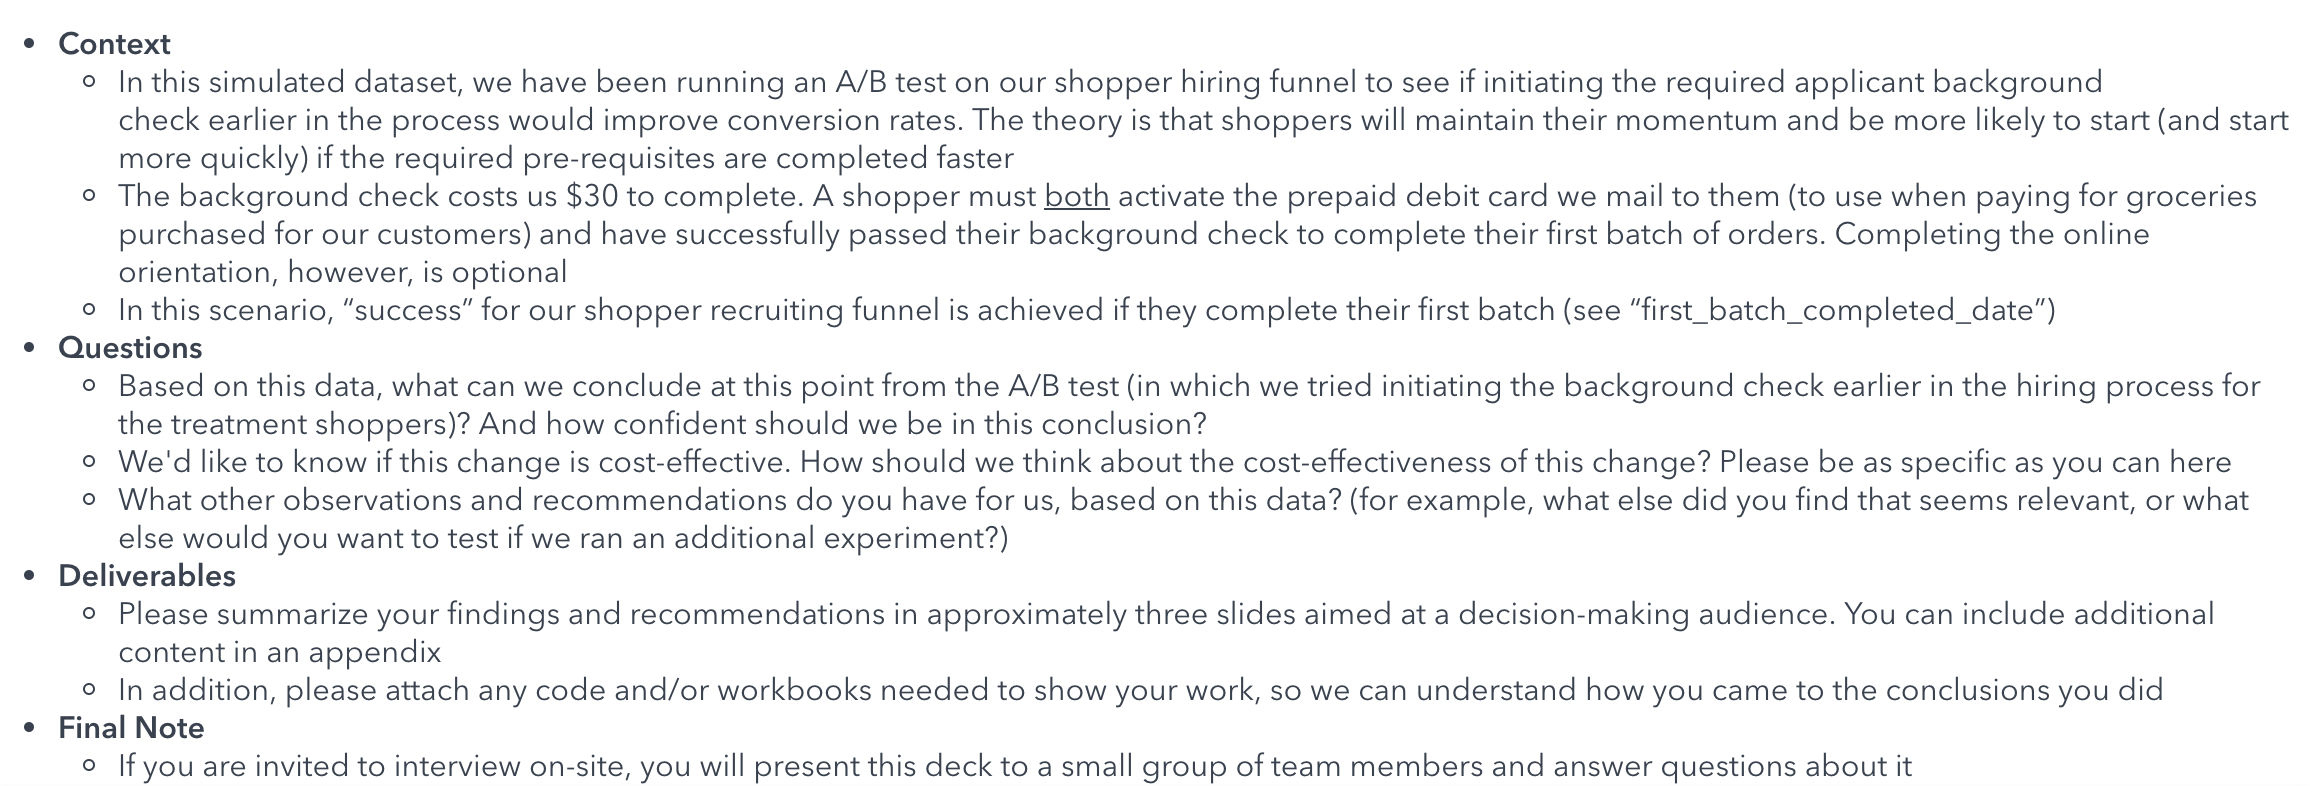

In [503]:
from IPython.display import Image

path = r"./description.png"
Image(filename = path, width=1000, height=1000)

PATH = "/Users/reblochonMasque/Documents/Drawings/"
Image(filename = PATH + "My_picture.jpg", width=100, height=100)

In [37]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import scipy.stats as stats

%matplotlib inline

## Step1: Load and Clean Data
- Since it is simulated data, which doesn't have missing value. The only data cleaning I did is time transformation from str to datetime.

In [504]:
dat.head()

,applicant_id,channel,group,city,event,event_date,date
0,10001,web-search-engine,control,Asgard,application_date,10/1/18,2018-10-01
1,10002,social-media,control,Midgard,application_date,10/1/18,2018-10-01
2,10003,web-search-engine,treatment,Midgard,application_date,10/1/18,2018-10-01
3,10004,social-media,treatment,Asgard,application_date,10/1/18,2018-10-01
4,10005,social-media,treatment,Midgard,application_date,10/1/18,2018-10-01


In [102]:
dat = pd.read_csv(r'./applicant_data.csv')
dat['date'] = pd.to_datetime(dat['event_date'], format='%x')

In [547]:
# Unique_applicant for each event
applicant_ct = dat.groupby(
    ['event', 'group'], as_index=False
).agg(
    {'applicant_id':'nunique'}
).rename(
    columns = {'applicant_id':'unique_applicant'}
)
applicant_ct

,event,group,unique_applicant
0,application_date,control,14501
1,application_date,treatment,7197
2,background_check_completed_date,control,9456
3,background_check_completed_date,treatment,6384
4,background_check_initiated_date,control,10836
5,background_check_initiated_date,treatment,7197
6,card_activation_date,control,10836
7,card_activation_date,treatment,5889
8,card_mailed_date,control,14266
9,card_mailed_date,treatment,7071


## Step2: Shopper Application Process Overview(control vs treatment)

### 2.1: Event Order

In [540]:
dat_without_orientation = dat[dat.event != 'orientation_completed_date']
dat_without_orientation['event_order'] = dat_without_orientation.groupby(['group','applicant_id'])['date'].rank(method = 'min')

### Control
- the cards were mailed at the same time or right after application submitted.
- Backgroupd check won't be initiated until the cards are activated
- first batch can only be completed after background check completed

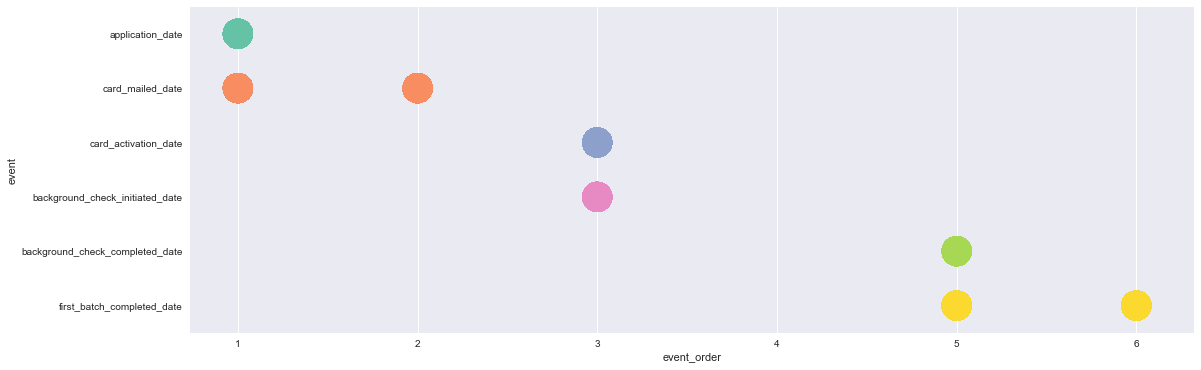

In [541]:
fig, ax = plt.subplots(figsize = (18,6))
ax =  sns.stripplot(x="event_order", y="event", data=dat_without_orientation[dat_without_orientation.group == 'control'],
                    palette="Set2", size=30, marker="o",
                    edgecolor="gray", alpha=.25,
                   ax = ax)

### Treatment
- Cards were mailed at the same day of or right after application submitted.
- Backgroupd check are initiated at the same day of application summitted.
- Card activation and Bcakground cherch are running simultaneously.
- first batch can be completed once background check completed and card activation done.

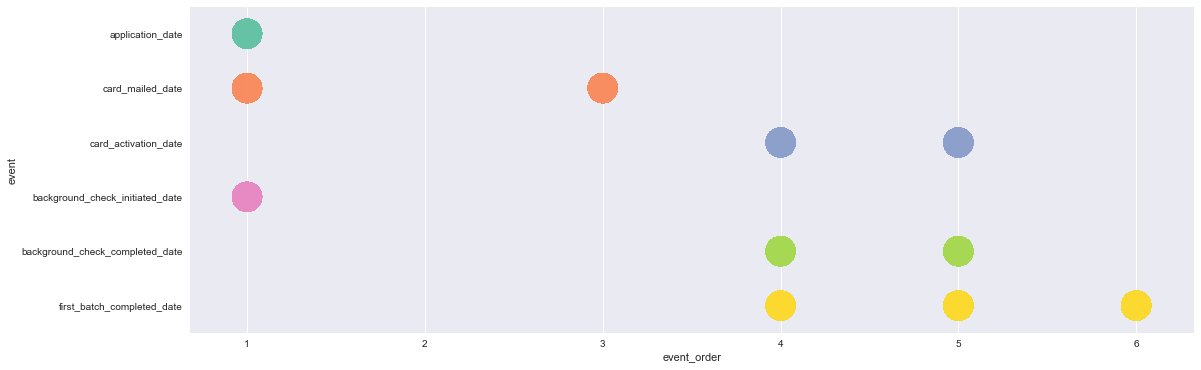

In [542]:
fig, ax = plt.subplots(figsize = (18,6))
ax =  sns.stripplot(x="event_order", y="event", data=dat_without_orientation[dat_without_orientation.group == 'treatment'],
                    palette="Set2", size=30, marker="o",
                    edgecolor="gray", alpha=.25,
                   ax = ax)

### 2.2 Event Days
days difference between events and application

In [483]:
days_diff = dat[
    dat.event == 'application_date'
][['applicant_id', 
   'group',
   'date']].merge(
    dat[dat.event == 'background_check_initiated_date'][['applicant_id', 'date']],
    how = 'left',
    on = 'applicant_id',
    suffixes = ('_app', '_bg_ini')
).merge(
    dat[dat.event == 'card_mailed_date'][['applicant_id', 'date']],
    how = 'left',
    on = 'applicant_id'
).merge(
    dat[dat.event == 'card_activation_date'][['applicant_id', 'date']],
    how = 'left',
    on = 'applicant_id',
    suffixes = ('_card_mail', '_card_act')
).merge(
    dat[dat.event == 'background_check_completed_date'][['applicant_id', 'date']],
    how = 'left',
    on = 'applicant_id'
).merge(
    dat[dat.event == 'first_batch_completed_date'][['applicant_id', 'date']],
    how = 'left',
    on = 'applicant_id',
    suffixes = ('_bg_comp', '_frt_batch')
)
days_diff['Background_Check_Initiated'] = ((days_diff['date_bg_ini'] - days_diff['date_app'])/ np.timedelta64(1, 'D')).astype(float)
days_diff['Background_Check_Completed'] = ((days_diff['date_bg_comp'] - days_diff['date_app'])/ np.timedelta64(1, 'D')).astype(float)
days_diff['Card_Mailed'] = ((days_diff['date_card_mail'] - days_diff['date_app'])/ np.timedelta64(1, 'D')).astype(float)
days_diff['Card_Activation'] = ((days_diff['date_card_act'] - days_diff['date_app'])/ np.timedelta64(1, 'D')).astype(float)
days_diff['First_Batch_Completed'] = ((days_diff['date_frt_batch'] - days_diff['date_app'])/ np.timedelta64(1, 'D')).astype(float)

event_list = []
for col in ['Background_Check_Initiated', 'Background_Check_Completed', 'Card_Mailed','Card_Activation', 'First_Batch_Completed']:
    df = days_diff[~days_diff[col].isnull()][['group', col]].rename(columns = {col:'Num_Days_after_Application'})
    df['events'] = col
    event_list.append(df)
days_diff_events = pd.concat(event_list, axis = 0)

### Control
- Order: Card_Mail

In [544]:
# fig, ax = plt.subplots(figsize = (18,6))
# sns.stripplot(x="Num_Days_after_Application", y="events", data=days_diff_events[days_diff_events.group == 'control'],
#                     palette="Set2", size=30, marker=".",
#                     edgecolor="gray", alpha=.25,
#                    order = ['Card_Mailed',
#                             'Card_Activation',
#                             'Background_Check_Initiated', 
#                             'Background_Check_Completed'
#                             , 'First_Batch_Completed'],
#                     jitter=False,
#                    ax = ax)
# plt.show()

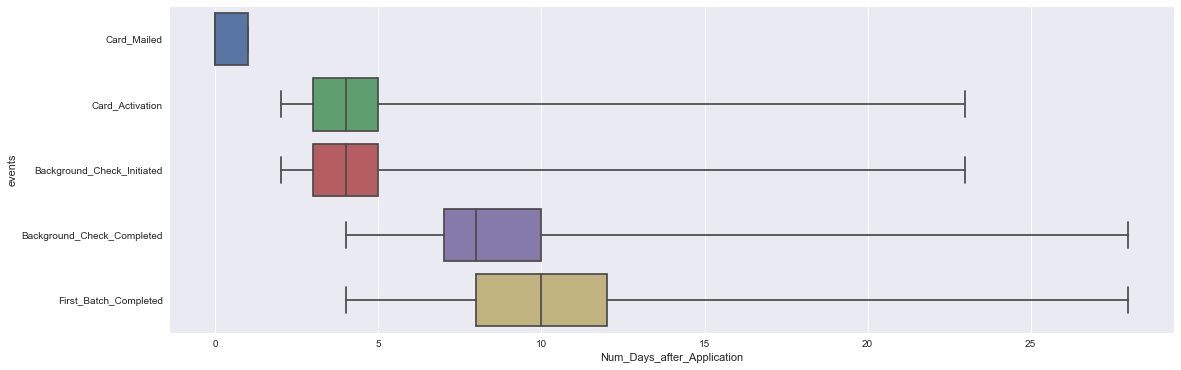

In [526]:
fig, ax = plt.subplots(figsize = (18,6))
sns.boxplot(x="Num_Days_after_Application", y="events", data=days_diff_events[days_diff_events.group == 'control'],
            whis=np.inf, ax = ax,
           order = ['Card_Mailed',
                            'Card_Activation',
                            'Background_Check_Initiated', 
                            'Background_Check_Completed'
                            , 'First_Batch_Completed'])
plt.show()

### Treatment
- background check initiation started right 

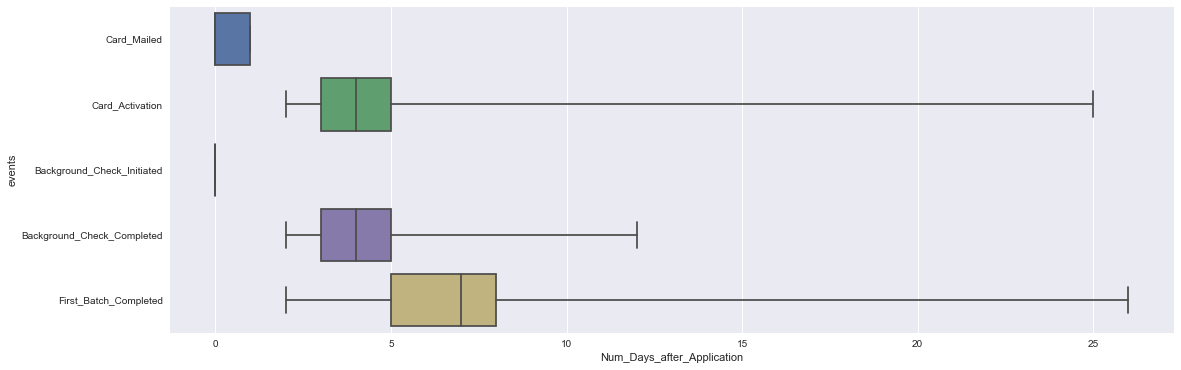

In [527]:
fig, ax = plt.subplots(figsize = (18,6))
sns.boxplot(x="Num_Days_after_Application", y="events", data=days_diff_events[days_diff_events.group == 'treatment'],
            whis=np.inf, ax = ax,
           order = ['Card_Mailed',
                            'Card_Activation',
                            'Background_Check_Initiated', 
                            'Background_Check_Completed'
                            , 'First_Batch_Completed'])
plt.show()

In [545]:
# fig, ax = plt.subplots(figsize = (18,6))
# ax =  sns.stripplot(x="Num_Days_after_Application", y="events", data=days_diff_events[days_diff_events.group == 'treatment'],
#                     palette="Set2", size=30, marker=".",
#                     edgecolor="gray", alpha=.25,
#                    order = ['Card_Mailed',
#                             'Card_Activation',
#                             'Background_Check_Initiated', 
#                             'Background_Check_Completed'
#                             , 'First_Batch_Completed'],
#                    ax = ax)

In [499]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# sns.distplot(df1[df1.group == 'treatment']['days_diff_app_bg'] , color="blue", ax=ax[0])
# sns.distplot(df1[df1.group == 'control']['days_diff_app_bg'], ax = ax[1])
# plt.show()

## Step 3: Sanity Check

Use Random Forest to check if the sample are assigned into control and treament groups by testing if any other info have predictive power to the sample assignment

In [488]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 days 19 hours 37 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_wenqicheng_juqbca
H2O cluster total nodes:,1
H2O cluster free memory:,1.608 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [489]:
# Transform to H2O frame
h2o_dat = h2o.H2OFrame(dat[dat.event == 'application_date'])

# Target variable is 'test'
h2o_dat['group'] = h2o_dat['group'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [490]:
feature = ['applicant_id', 'city', 'channel', 'event_date']
target = 'group'

random_forest = H2ORandomForestEstimator(ntrees = 100,
                                         max_depth = 4,
                                         mtries = 2,
                                         seed = 2019)

random_forest.train(x=feature, y= target, training_frame = h2o_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


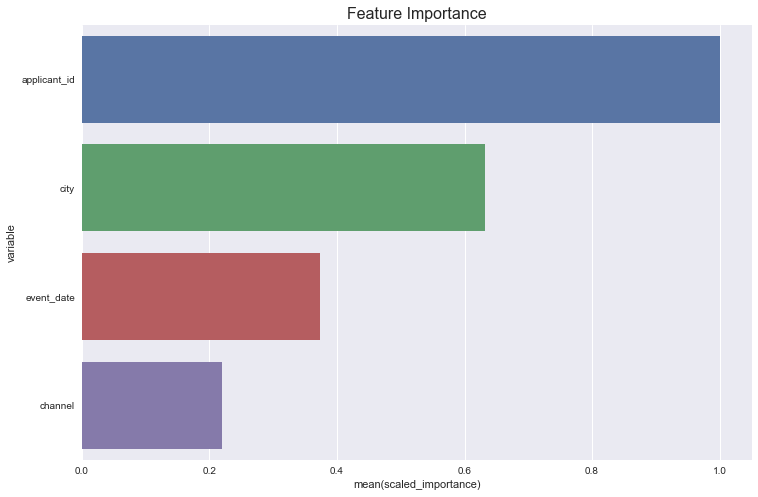

In [491]:
# Feature Importance
importance = random_forest.varimp(use_pandas = True)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
ax.set_title('Feature Importance', fontsize=16)
plt.show()

## Step 4: Metrics Evaluation

In [ ]:
def proportion_ztest_two_samples(count, nobs, alpha=0.05, alter = 'two-sided'):
    z, pvalue = proportions_ztest(count, nobs, value=0, alternative= alter)
    
    x1 = np.array(count)[0]
    x2 = np.array(count)[1]
    
    n1 = np.array(nobs)[0]
    n2 = np.array(nobs)[1]
    
    p1 = float(x1)/n1 #control
    p2 = float(x2)/n2 #treatment
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

    z_critical = stats.norm.ppf(1-0.5*alpha)
    return(z, pvalue,round(p1,4), round(p2,4), round(p1-p2-z_critical*se, 5), round(p1-p2+z_critical*se,5))

### 4.1: Card Mail Rate 
- num of cards mailed divided by num of applications
- It's not suppose to be changed

In [548]:
z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'card_mailed_date']['unique_applicant'], 
    applicant_ct[applicant_ct.event == 'application_date']['unique_applicant']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = 0.705689642484 
p-value = 0.480381163491
Rate of control: 0.9838
Rate of treatment:0.9825
Confidence Interval of (p_countrol - p_treatment): (-0.00236, 0.00496)


### 4.2 Card Activatioin Rate
- num of cards activated divided by num of carded mailed

In [549]:
z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'card_activation_date']['unique_applicant'], 
    applicant_ct[applicant_ct.event == 'card_mailed_date']['unique_applicant']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = -12.2393279991 
p-value = 1.91612494233e-34
Rate of control: 0.7596
Rate of treatment:0.8328
Confidence Interval of (p_countrol - p_treatment): (-0.08444, -0.0621)


### 4.3 Background check initiated rate
- num of background check initiated divided by num of applications

In [550]:
z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'background_check_initiated_date']['unique_applicant'], 
    applicant_ct[applicant_ct.event == 'application_date']['unique_applicant']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = -46.7831678066 
p-value = 0.0
Rate of control: 0.7473
Rate of treatment:1.0
Confidence Interval of (p_countrol - p_treatment): (-0.25981, -0.24567)


### 4.4 Background check completed rate
- num of background check completed divided by num of background check initiated

In [551]:
z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'background_check_completed_date']['unique_applicant'], 
    applicant_ct[applicant_ct.event == 'background_check_initiated_date']['unique_applicant']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = -2.89530290232 
p-value = 0.00378792823502
Rate of control: 0.8726
Rate of treatment:0.887
Confidence Interval of (p_countrol - p_treatment): (-0.02403, -0.00475)


### 4.5 First batch completed rate 1
- num of batch completed divided by num of applications

In [552]:
z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'first_batch_completed_date']['unique_applicant'], 
    applicant_ct[applicant_ct.event == 'application_date']['unique_applicant']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = -23.3746737257 
p-value = 7.73568429114e-121
Rate of control: 0.1981
Rate of treatment:0.3433
Confidence Interval of (p_countrol - p_treatment): (-0.15796, -0.13247)


### 4.6 First batch completed rate
- num of batch completed divided by num of applicants who pass the background check and active the cards

In [588]:
BG_ck_comp_Card_activation = dat[
    dat.event.isin(['background_check_completed_date',
                    'card_activation_date'])
].groupby(['group','applicant_id'], as_index = False).agg({'event':'nunique'})

card_bg = BG_ck_comp_Card_activation[
    BG_ck_comp_Card_activation.event == 2
].groupby('group', 
          as_index = False).agg({'applicant_id':'nunique'})

z, pvalue, p1, p2, cf_low, cf_up = proportion_ztest_two_samples(
    applicant_ct[applicant_ct.event == 'first_batch_completed_date']['unique_applicant'],
    card_bg['applicant_id']
)
print('z-stat = {z} \np-value = {p}'.format(z=z,p=pvalue))
print('Rate of control: ' +  str(p1) + '\n' +'Rate of treatment:'+ str(p2))
print('Confidence Interval of (p_countrol - p_treatment): ' + str((cf_low, cf_up)))

z-stat = -15.5395438642 
p-value = 1.87311865424e-54
Rate of control: 0.3038
Rate of treatment:0.4277
Confidence Interval of (p_countrol - p_treatment): (-0.1396, -0.10806)


### 4.7: Days spent of the sucess recruiting
- num of days between application submitted and first batch completed

## Step 5: Cost Effect

- Beckground check initiated rate raises from 74.7% to 100%
- Each background check cost 30 dollars, which means the background check cost increases by (25.3% \* num_applications \* 30dollars per appliaction)
- First batch completed rate raises from 19.8% to 34.3%, which mean the profit increases by (14.5% \* num_applications \* profit per shopper)
- Profit change: (34.3 * profit1 - 19.8 * profit2) - (100 - 74.7)*$30. 
    - profit1 is the avg profit created by a shopper in treatment group
    - profit2 is the avg profit created by a shopper in control group
    - If profit1 = profit2 = profit, the breakeven profit/shopper:  (100 - 74.7) * 30dollars/(34.3 - 19.8) = 52.34 dollars/ shopper

In [572]:
conversion_rate = applicant_ct.merge(
    applicant_ct[applicant_ct.event == 'application_date'],
    on = ['group'],
    how = 'inner',
    suffixes = ('', '_application')
)
conversion_rate['rate'] = conversion_rate['unique_applicant']/conversion_rate['unique_applicant_application']
conversion_rate.sort_values('event')

,event,group,unique_applicant,event_application,unique_applicant_application,rate
0,application_date,control,14501,application_date,14501,1.000000
7,application_date,treatment,7197,application_date,7197,1.000000
1,background_check_completed_date,control,9456,application_date,14501,0.652093
8,background_check_completed_date,treatment,6384,application_date,7197,0.887036
2,background_check_initiated_date,control,10836,application_date,14501,0.747259
9,background_check_initiated_date,treatment,7197,application_date,7197,1.000000
3,card_activation_date,control,10836,application_date,14501,0.747259
10,card_activation_date,treatment,5889,application_date,7197,0.818258
4,card_mailed_date,control,14266,application_date,14501,0.983794
11,card_mailed_date,treatment,7071,application_date,7197,0.982493


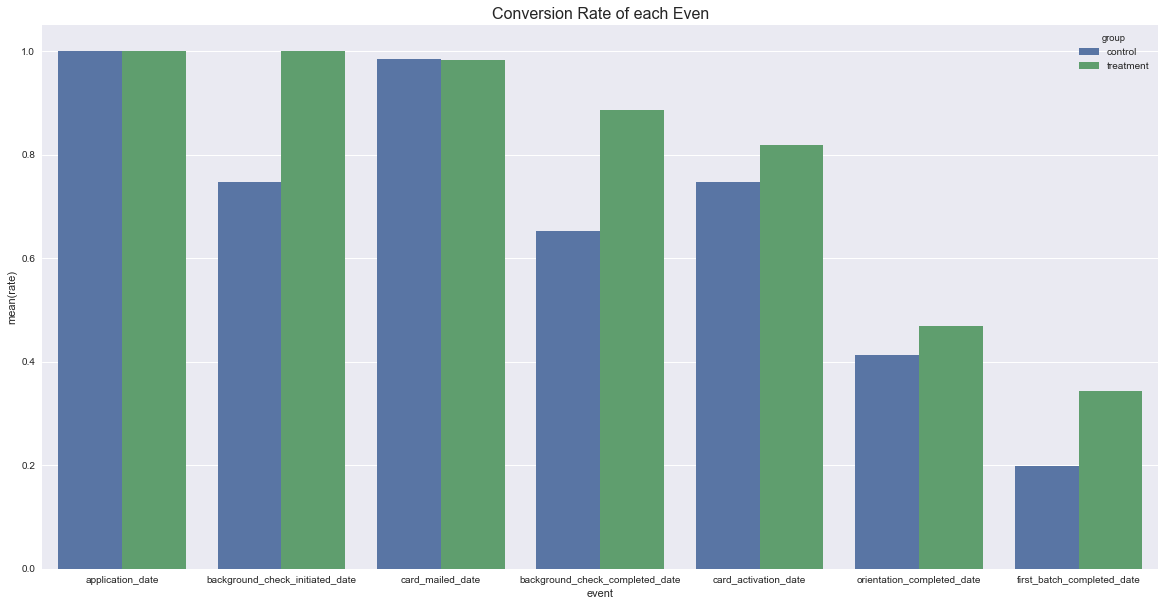

In [570]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x='event', y = 'rate', hue='group', data=conversion_rate.sort_values(['rate'], ascending = False), ax=ax)
ax.set_title('Conversion Rate of each Even', fontsize=16)
plt.show()

In [589]:
dat.head()

,applicant_id,channel,group,city,event,event_date,date,event_order
0,10001,web-search-engine,control,Asgard,application_date,10/1/18,2018-10-01,1.0
1,10002,social-media,control,Midgard,application_date,10/1/18,2018-10-01,1.0
2,10003,web-search-engine,treatment,Midgard,application_date,10/1/18,2018-10-01,1.0
3,10004,social-media,treatment,Asgard,application_date,10/1/18,2018-10-01,1.0
4,10005,social-media,treatment,Midgard,application_date,10/1/18,2018-10-01,1.0


In [614]:
df1.head()

,event,city,group,unique_applicant
0,application_date,Alfheim,control,1253
1,application_date,Alfheim,treatment,612
2,application_date,Asgard,control,4601
3,application_date,Asgard,treatment,2306
4,application_date,Helheim,control,103


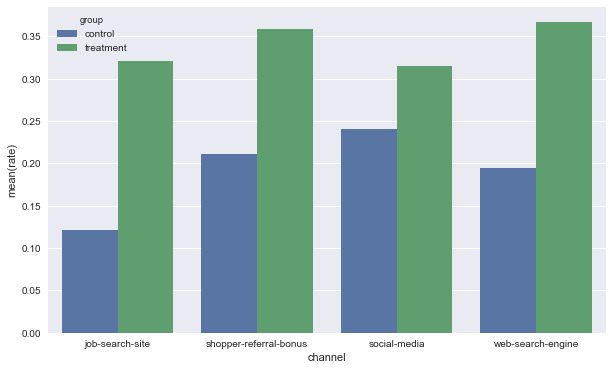

In [609]:
df1 = dat.groupby(
    ['event','channel', 'group'], as_index=False
).agg(
    {'applicant_id':'nunique'}
).rename(
    columns = {'applicant_id':'unique_applicant'}
)


df2 = df1.merge(
    df1[df1.event == 'application_date'],
    on = ['group', 'channel'],
    how = 'inner',
    suffixes = ('', '_application')
)
df2['rate'] = df2['unique_applicant']/df2['unique_applicant_application']

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='channel', y = 'rate', hue='group', data= df2[df2.event =='first_batch_completed_date'], ax=ax)
plt.show()

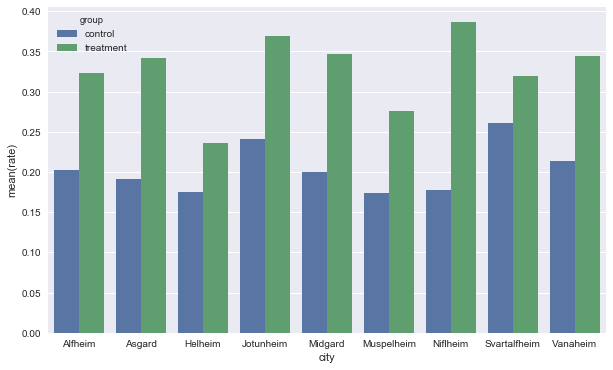

In [611]:
df1 = dat.groupby(
    ['event','city', 'group'], as_index=False
).agg(
    {'applicant_id':'nunique'}
).rename(
    columns = {'applicant_id':'unique_applicant'}
)


df2 = df1.merge(
    df1[df1.event == 'application_date'],
    on = ['group', 'city'],
    how = 'inner',
    suffixes = ('', '_application')
)
df2['rate'] = df2['unique_applicant']/df2['unique_applicant_application']

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='city', y = 'rate', hue='group', data= df2[df2.event =='first_batch_completed_date'], ax=ax)
plt.show()

In [622]:
df3 = dat[
    dat.event.isin(['background_check_completed_date',
                    'card_activation_date'])
].groupby(['channel','group','applicant_id'], as_index = False).agg({'event':'nunique'})

df4 = df3[df3.event == 2].groupby(['channel','group'], as_index = False).agg({'applicant_id':'nunique'}).rename(
    columns = {'applicant_id':'unique_applicant'}
)
df4

,channel,group,unique_applicant
0,job-search-site,control,1327
1,job-search-site,treatment,896
2,shopper-referral-bonus,control,1571
3,shopper-referral-bonus,treatment,933
4,social-media,control,2965
5,social-media,treatment,1663
6,web-search-engine,control,3593
7,web-search-engine,treatment,2286


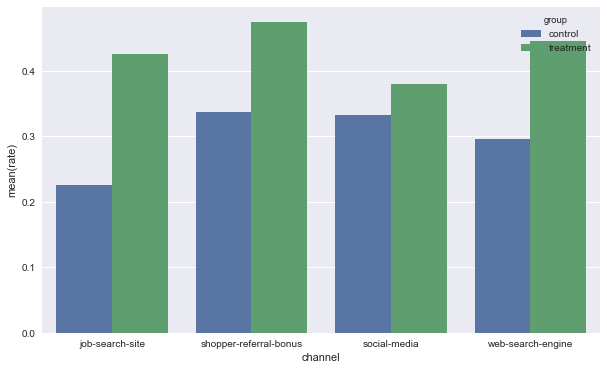

In [643]:
df1 = dat[dat.event == 'first_batch_completed_date'].groupby(
    ['event','channel', 'group'], as_index=False
).agg(
    {'applicant_id':'nunique'}
).rename(
    columns = {'applicant_id':'unique_applicant'}
)


df2 = df4.merge(
    df1,
    on = ['group', 'channel'],
    how = 'inner',
    suffixes = ('_bg_card', '')
)
df2['rate'] = df2['unique_applicant']/df2['unique_applicant_bg_card']

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='channel', y = 'rate', hue='group', data= df2[df2.event =='first_batch_completed_date'], ax=ax)
plt.show()